# Run and process the prior monte carlo and pick a "truth" realization

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

flopy is installed in /Users/jeremyw/Dev/flopy/flopy


In [2]:
t_d = "template"
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))

### run the prior ensemble in parallel locally

In [3]:
m_d = "master_prior_sweep"
#pyemu.os_utils.start_slaves(t_d,"pestpp-swp","freyberg.pst",num_slaves=20,slave_root=".",master_dir=m_d)

### Load the output ensemble and plot a few things

The observations with the `fa_hw` tag are "flow aquifer" outputs from the SFR ASCII output file and the `hw` is for the "headwaters" cumulative flow aquifer for the upper 20 reaches

In [4]:
obs = pst.observation_data
swgw = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
swgw

obsnme
fa_hw_19791230    fa_hw_19791230
fa_hw_19801229    fa_hw_19801229
Name: obsnme, dtype: object

Two forecasts - one during the historical period, and one during the scenario period

In [5]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
obs_df.shape

(200, 4461)

drop any failed runs

In [6]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
obs_df.shape

(200, 4461)

In [7]:
#obs_df.phi.apply(np.log10).hist(bins=20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x182518d048>,
      dtype=object)

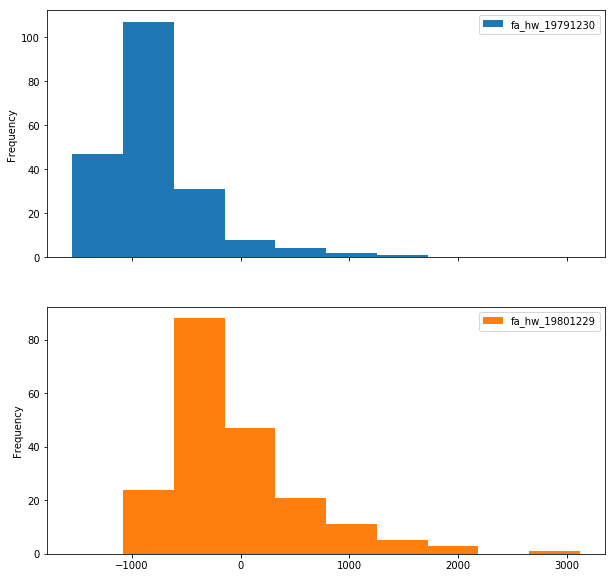

In [8]:
obs_df.loc[:,swgw].plot(kind="hist",subplots=True,figsize=(10,10))

We see that under scenario conditions, many more realizations for the flow to the aquifer in the headwaters are postive (as expected).  Lets difference these two:

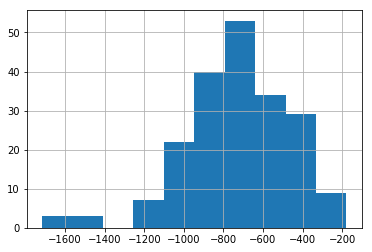

In [9]:
diff = obs_df.loc[:,swgw[0]] - obs_df.loc[:,swgw[1]]
diff.hist()

We now see that the most extreme scenario yields a large decrease in flow from the aquifer to the headwaters (the most negative value)

In [10]:
diff_sort = diff.sort_values()
diff_sort.head()

run_id
67    -1716.900716
63    -1624.352450
182   -1574.195200
163   -1533.029090
54    -1445.568200
dtype: float64

We just need to replace the observed values (`obsval`) in the control file with the outputs for one of the realizations on `obs_df`.  In this way, we now have the nonzero values for history matching, but also the ``truth`` values for comparing how we are doing with other unobserved quantities.  Im going to pick a realization that yields an "average" variability of the observed gw levels:

In [18]:
# choose the realization with a historic gw to sw flux
hist_swgw = obs_df.loc[:,swgw[0]].sort_values()
idx = hist_swgw.index[20]

In [19]:
obs_df.loc[idx,pst.nnz_obs_names]

hds_00_002_009_000    36.111198
hds_00_002_015_000    34.547726
hds_00_003_008_000    36.255306
hds_00_009_001_000    37.375320
hds_00_013_010_000    35.085289
hds_00_015_016_000    34.512516
hds_00_021_010_000    35.091419
hds_00_022_015_000    34.336319
hds_00_024_004_000    36.188076
hds_00_026_006_000    35.553226
hds_00_029_015_000    34.484158
hds_00_033_007_000    34.540997
hds_00_034_010_000    34.122837
Name: 106, dtype: float64

Lets see how our selected truth does with the swgw forecasts:

In [20]:
print(obs_df.loc[idx,swgw])
print(diff_sort.loc[idx])

fa_hw_19791230   -1230.13130
fa_hw_19801229    -411.48421
Name: 106, dtype: float64
-818.6470899999999


In [39]:
obs = pst.observation_data
obs.loc[:,"obsval"] = obs_df.loc[idx,pst.obs_names]
obs.loc[obs.obgnme=="calhead","weight"] = 10.0
obs.loc["fo_39_19791230","weight"] = 0.01
obs.weight.value_counts()

0.00     4420
10.00      13
0.01        1
Name: weight, dtype: int64

Now, it is custom to add noise to the observed values...we will use the classic Gaussian noise...zero mean and standard deviation of 1 over the weight

In [40]:
# np.random.seed = 0
# print(np.random.seed)
# std = 1.0 / pst.observation_data.loc[pst.nnz_obs_names,"weight"].mean()
# noise = np.random.normal(0,std,size=pst.nnz_obs)
# pst.observation_data.loc[pst.nnz_obs_names,"obsval"] += noise

In [58]:
pst.write(os.path.join(t_d,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=t_d)

In [42]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

997.5479048847845


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,flout,12759.000000,11430.000000,1329.000000,0.1
hds_00_002_009_000,hds_00_002_009_000,calhead,36.111198,37.107498,-0.996300,10.0
hds_00_002_015_000,hds_00_002_015_000,calhead,34.547726,35.045185,-0.497459,10.0
hds_00_003_008_000,hds_00_003_008_000,calhead,36.255306,37.397289,-1.141983,10.0
hds_00_009_001_000,hds_00_009_001_000,calhead,37.375320,39.546417,-2.171097,10.0
hds_00_013_010_000,hds_00_013_010_000,calhead,35.085289,35.571774,-0.486485,10.0
hds_00_015_016_000,hds_00_015_016_000,calhead,34.512516,34.835716,-0.323200,10.0
hds_00_021_010_000,hds_00_021_010_000,calhead,35.091419,35.386250,-0.294830,10.0
hds_00_022_015_000,hds_00_022_015_000,calhead,34.336319,34.577492,-0.241173,10.0


In [43]:
pst.phi_components
#pst.plot(kind='phi_pie')

{'calhead': 820.9238048847845,
 'flaqx': 0.0,
 'flout': 176.62410000000003,
 'flx_constan': 0.0,
 'flx_drains': 0.0,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_storage': 0.0,
 'flx_stream_': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'hds': 0.0,
 'vol_constan': 0.0,
 'vol_drains': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_storage': 0.0,
 'vol_stream_': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

Just to make sure we have everything working right, we should be able to load the truth parameters, run the model once and have a (near-)zero `phi`:

In [44]:
par_df = pd.read_csv(os.path.join(m_d,"sweep_in.csv"),index_col=0)
pst.parameter_data.loc[:,"parval1"] = par_df.loc[idx,pst.par_names]
pst.write(os.path.join(m_d,"test.pst"))
pyemu.os_utils.run("pestpp-ies.exe test.pst",cwd=m_d)

In [45]:
pst = pyemu.Pst(os.path.join(m_d,"test.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

1.3963368803880017e-16


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,flout,12759.000000,12759.000000,0.000000e+00,0.01
hds_00_002_009_000,hds_00_002_009_000,calhead,36.111198,36.111198,-2.929710e-10,10.00
hds_00_002_015_000,hds_00_002_015_000,calhead,34.547726,34.547726,-4.902319e-10,10.00
hds_00_003_008_000,hds_00_003_008_000,calhead,36.255306,36.255306,1.035190e-10,10.00
hds_00_009_001_000,hds_00_009_001_000,calhead,37.375320,37.375320,4.296865e-10,10.00
hds_00_013_010_000,hds_00_013_010_000,calhead,35.085289,35.085289,-4.648442e-10,10.00
hds_00_015_016_000,hds_00_015_016_000,calhead,34.512516,34.512516,2.714842e-10,10.00
hds_00_021_010_000,hds_00_021_010_000,calhead,35.091419,35.091419,2.929568e-11,10.00
hds_00_022_015_000,hds_00_022_015_000,calhead,34.336319,34.336319,2.734382e-10,10.00


Lets load the model and check some things

In [46]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=m_d)

6.169213e-05 7.30278e-05


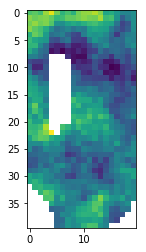

In [47]:
#a = m.upw.hk[0].array
a = m.rch.rech[0].array
a = np.ma.masked_where(m.bas6.ibound[0].array==0,a)
print(a.min(),a.max())
plt.imshow(a)

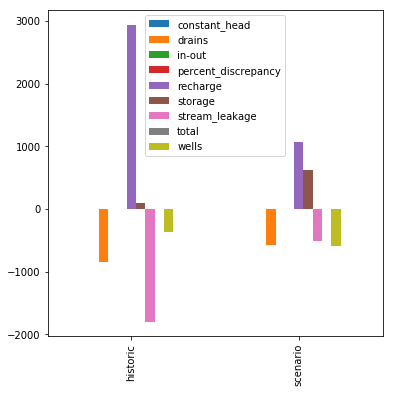

In [57]:
lst = flopy.utils.MfListBudget(os.path.join(m_d,"freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6))
a = ax.set_xticklabels(["historic","scenario"],rotation=90)

### see how our existing observation ensemble compares to the truth

sw-gw outputs:

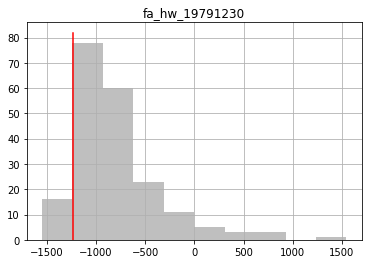

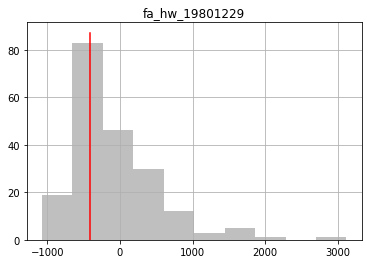

In [49]:
obs = pst.observation_data
swgws = obs.loc[obs.obsnme.apply(lambda x: "fa_hw" in x),"obsnme"]
for swgw in swgws:
    ax = plt.subplot(111)
    obs_df.loc[:,swgw].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[swgw,"obsval"],obs.loc[swgw,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(swgw)
    plt.show()

observations:

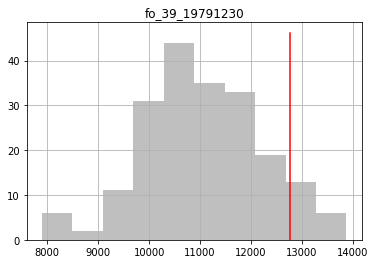

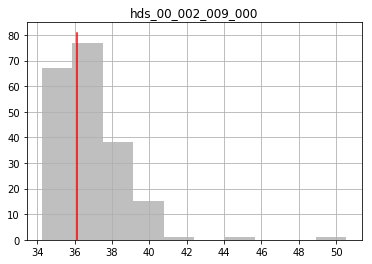

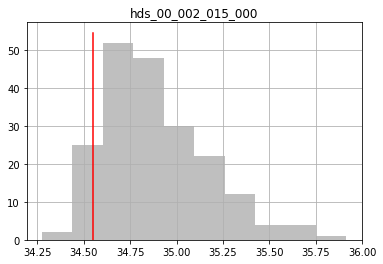

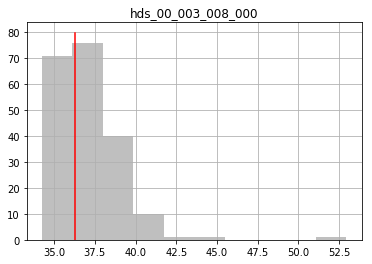

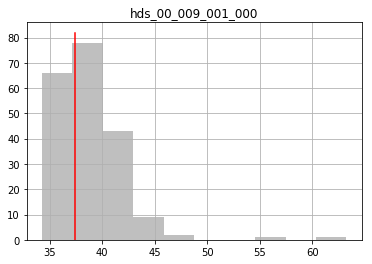

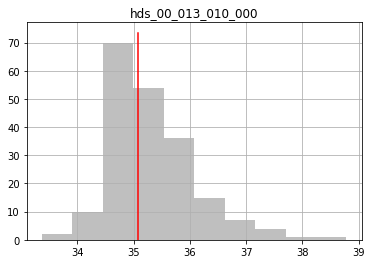

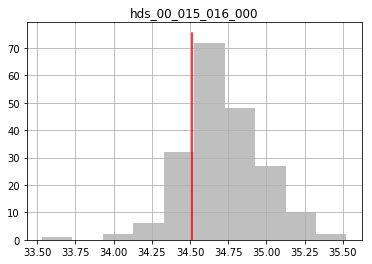

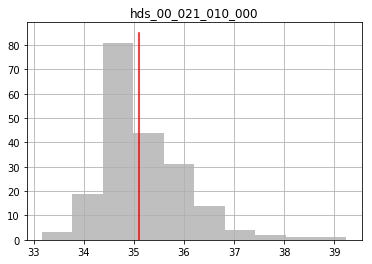

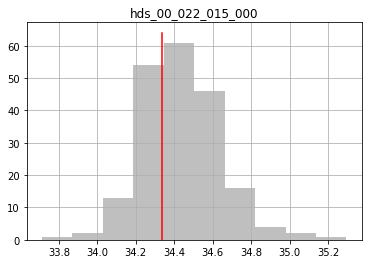

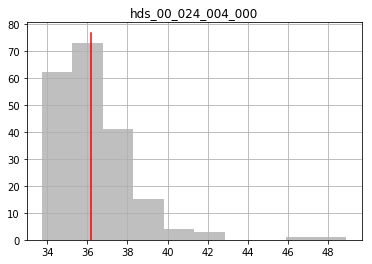

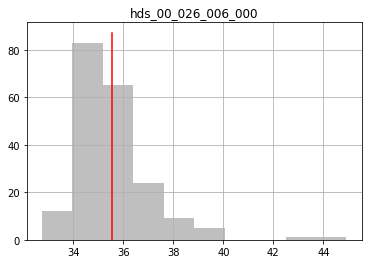

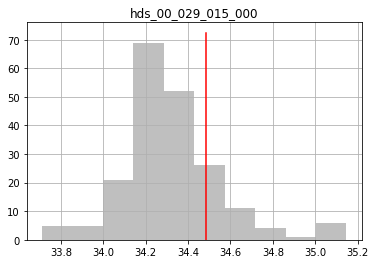

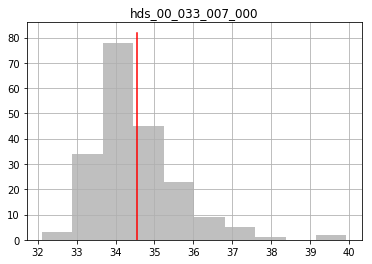

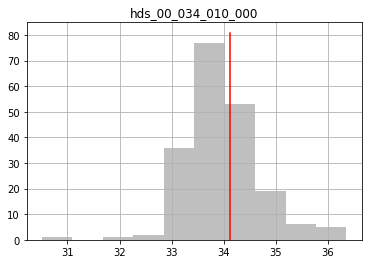

In [52]:
for oname in pst.nnz_obs_names:
    ax = plt.subplot(111)
    obs_df.loc[:,oname].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[oname,"obsval"],obs.loc[oname,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(oname)
    plt.show()